In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import ast

In [86]:
df = pd.read_csv('../../data/processed/df_clean.csv')
df

,title,original_language,release_date,budget,revenue,runtime,popularity,vote_average,vote_count,is_franchise,genres_names,production_companies_names,production_countries_names,keywords_names,cast_names,crew_names,similar_movies_names
0,Frankenstein,en,2025-10-17,120000000,144496,150,736.4639,7.873,1322,0,"['Drama', 'Horror', 'Fantasy']","['Double Dare You', 'Demilo Films', 'Bluegrass...","['United States of America', 'Canada']","['monster', 'based on novel or book', 'superna...","['Oscar Isaac', 'Jacob Elordi', 'Christoph Wal...","['J. Miles Dale', 'Dennis Berardi', 'Stacey Do...","['Doom', 'My Life as a Dog', '99 Francs', 'Cas..."
1,Playdate,en,2025-11-05,0,0,95,394.4340,6.497,150,0,"['Action', 'Comedy', 'Family']","['Nickel City Pictures', 'Wide Awake Pictures'...","['United States of America', 'Canada']","['stay-at-home dad', 'accountant', 'action com...","['Kevin James', 'Alan Ritchson', 'Sarah Chalke...","['Jason Benoit', 'Jeffrey Greenstein', 'Neil G...","['10', 'Love Hurts', 'The Last Airbender', 'Th..."
2,One Battle After Another,en,2025-09-23,130000000,200300000,162,376.4645,7.642,1317,0,"['Action', 'Thriller', 'Crime']","['Warner Bros. Pictures', 'Ghoulardi Film Comp...",['United States of America'],"['rebellion', 'based on novel or book', 'resis...","['Leonardo DiCaprio', 'Sean Penn', 'Chase Infi...","['Adam Somner', 'Cassandra Kulukundis', 'Paul ...","['Boy 7', '森中有林', 'American Psycho', 'The Unsu..."
3,Predator: Badlands,en,2025-11-05,105000000,136304836,107,279.0902,7.339,319,1,"['Action', 'Science Fiction', 'Adventure']","['20th Century Studios', 'Lawrence Gordon Prod...",['United States of America'],"['survival', 'outcast', 'alien planet', 'grand...","['Elle Fanning', 'Dimitrius Schuster-Koloamata...","['Patrick Aison', 'Dan Trachtenberg', 'Jim Tho...","['Day the World Ended', 'War Between the Plane..."
4,A Legend,zh,2024-07-05,0,11242056,129,254.0500,5.892,51,1,"['Action', 'Adventure', 'Fantasy']","['Bona Film Group', 'Just Creative Studio', 'S...","['China', 'Hong Kong']","['اسطورة', 'a legend', 'myth 2', 'professor fa...","['Jackie Chan', 'Zhang Yixing', 'Gulnezer Bext...","['Stanley Tong Gwai-Lai', 'Stanley Tong Gwai-L...","['UFC on ESPN 65: Emmett vs. Murphy', 'Rumble'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,The Lure,pl,2015-12-25,1300000,102986,93,4.9823,6.200,275,0,"['Horror', 'Music', 'Romance', 'Drama', 'Fanta...","['Telewizja Polska', 'Platige Image', 'Wytwórn...",['Poland'],"['mermaid', 'musical', 'woman director', '1980...","['Kinga Preis', 'Michalina Olszańska', 'Marta ...","['Marcin Lenarczyk', 'Joanna Macha', 'Janusz K...","['Dreamers', 'Violence and Sarcasm', 'Selma', ..."
2674,Misfit,es,2021-10-14,0,354068,90,4.9691,8.000,212,0,"['Comedy', 'Romance']","['Touché Films', '2btube']",['Ecuador'],"['high school', 'bullying', 'teen movie', 'tee...","['Alicia Jaziz Zapién', 'Julián Cerati', 'Gime...","['Bastian Manintveld', 'Fabienne Fourquet', 'G...","['Casper', 'The Karate Kid Part II', 'High Sch..."
2675,The Addams Family,en,2019-10-10,40000000,204394183,87,4.9816,6.605,2428,1,"['Family', 'Animation', 'Comedy', 'Fantasy']","['Cinesite Animation', 'Nitrogen Studios Canad...","['Canada', 'United States of America']","['cartoon', 'black humor', 'family']","['Oscar Isaac', 'Charlize Theron', 'Chloë Grac...","['Ellery Van Dooyeweert', 'Conrad Vernon', 'La...",['Raggedy Ann & Andy: The Great Santa Claus Ca...
2676,The Wave,no,2015-08-28,5904067,12975143,104,4.9800,6.688,1350,1,"['Action', 'Thriller', 'Drama']","['Fantefilm', 'Film i Väst', 'Tre Vänner']",['Norway'],"['hotel', 'fjord', 'tsunami', 'norway', 'disas...","['Kristoffer Joner', 'Ane Dahl Torp', 'Jonas H...","['Roar Uthaug', 'John Kåre Raake', 'Adrian Cur...","['The Core', 'Baader', 'The Wrong Bed: Naked P..."


In [87]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

---
# EDA
---

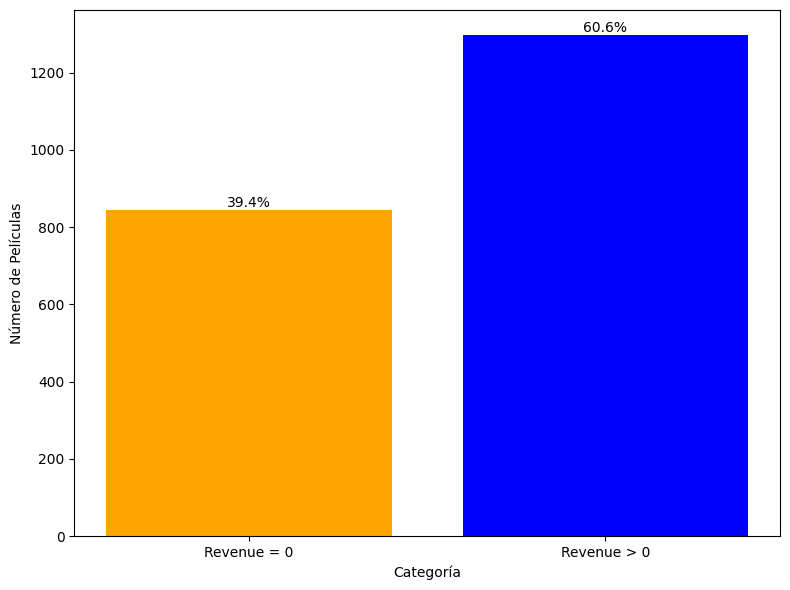

In [88]:
# Contar películas
y0 = (train_set["revenue"] == 0).sum()
y1 = (train_set["revenue"] > 0).sum()
total = len(train_set)

# Gráfico
categorias = ['Revenue = 0', 'Revenue > 0']
counts = [y0, y1]

plt.figure(figsize=(8, 6))
plt.bar(categorias, counts, color=['orange', 'blue'])
plt.ylabel('Número de Películas')
plt.xlabel('Categoría')

for i, count in enumerate(counts):
    porcentaje = (count / total) * 100
    plt.text(i, count, f'{porcentaje:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show();



* Tenemos un dataset ligeramente desbalanceado, con dos tipos de películas. 
Las que no obtienen taquilla ("revenue"), que son las películas de plataformas que no se estrenan en salas de cine, y las que sí, con taquilla positiva.
Para manejar el desbalanceo (64% de películas sin revenue), se implementará un modelo mixto, primero clasificación para identificar si una película generará ingresos, y luego regresión para predecir la cantidad.

---
### Analicemos primero las features numéricas.
---

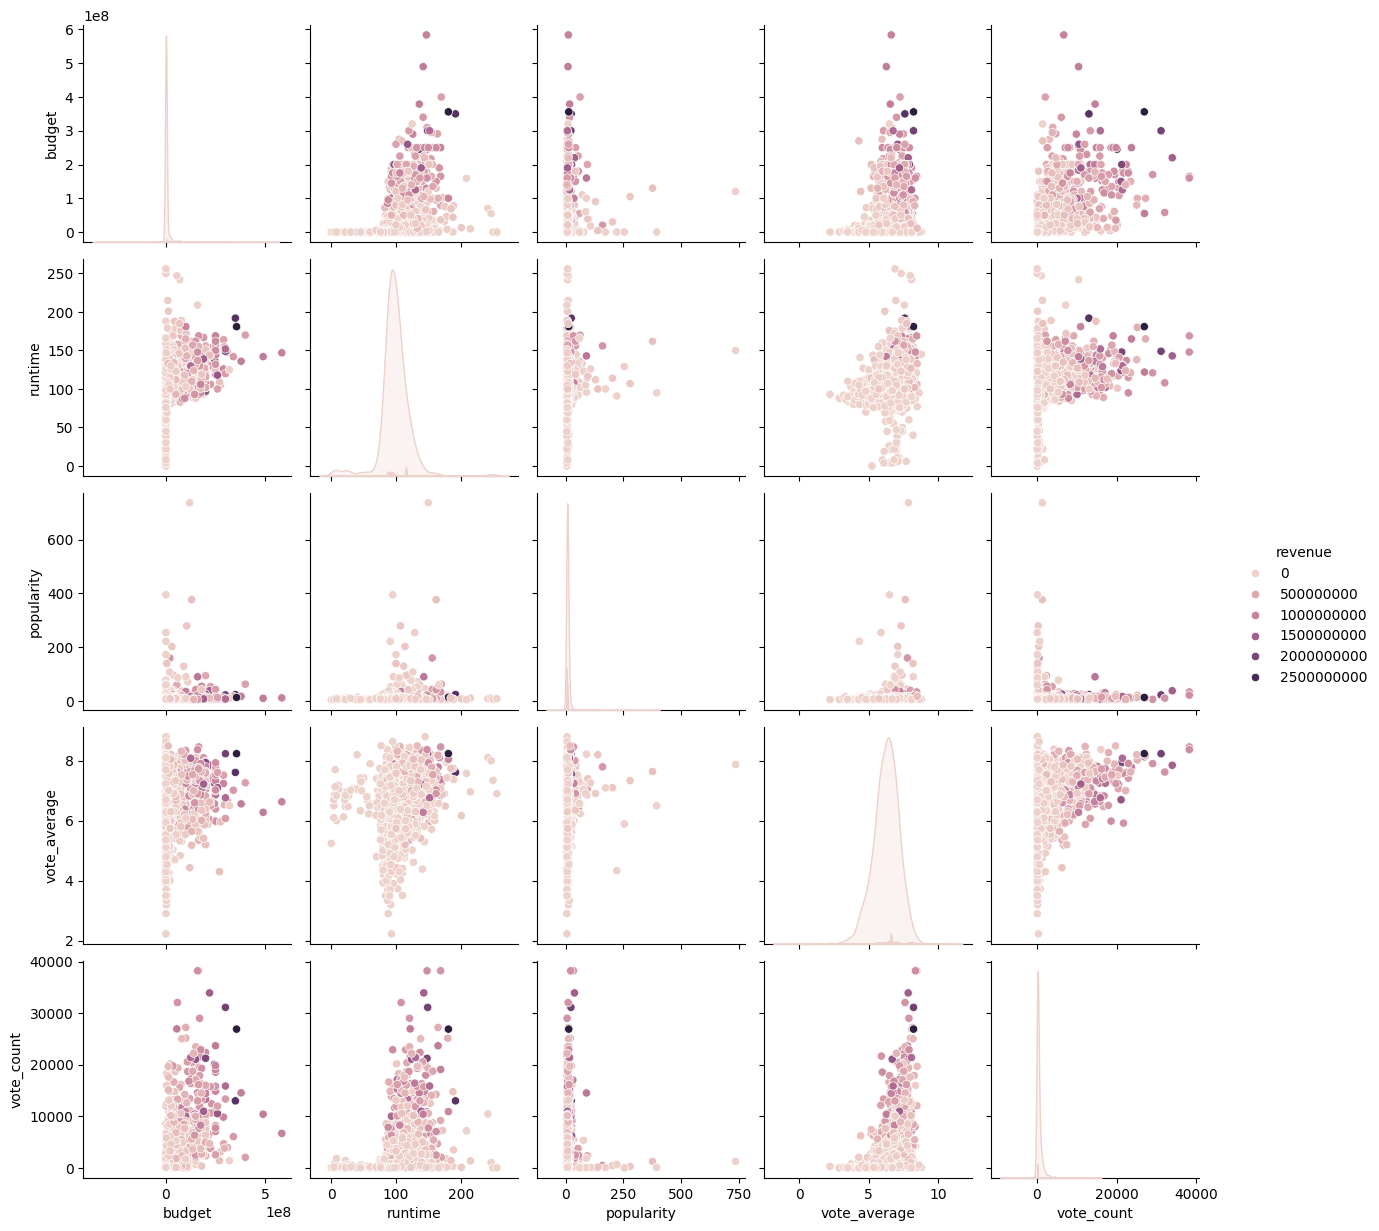

In [89]:
# Hagamos un pairplot
columnas_numericas = ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count']
sns.pairplot(train_set[columnas_numericas + ['revenue']], hue='revenue')
plt.show()

Vemos que budget presenta una relación positiva y parece ser la variable más indicativa para el revenue. En cuanto a runtime, podemos concluir que, en general, a mayor duración, mayor éxito comercial.

Popularity llama la atención por acumularse en 0, por lo que deberemos estudiarla con más profundidad.

Por último, para vote_average y vote_count observamos patrones claros, siendo más marcado en vote_count. A mayor número de votos, se prevé un mayor revenue



Veamos popularity y si necesita una transformacón como parece.

In [90]:
print(train_set['popularity'].describe())

count    2142.000000
mean       10.236074
std        23.943007
min         3.729800
25%         5.746775
50%         6.925150
75%         9.124350
max       736.463900
Name: popularity, dtype: float64


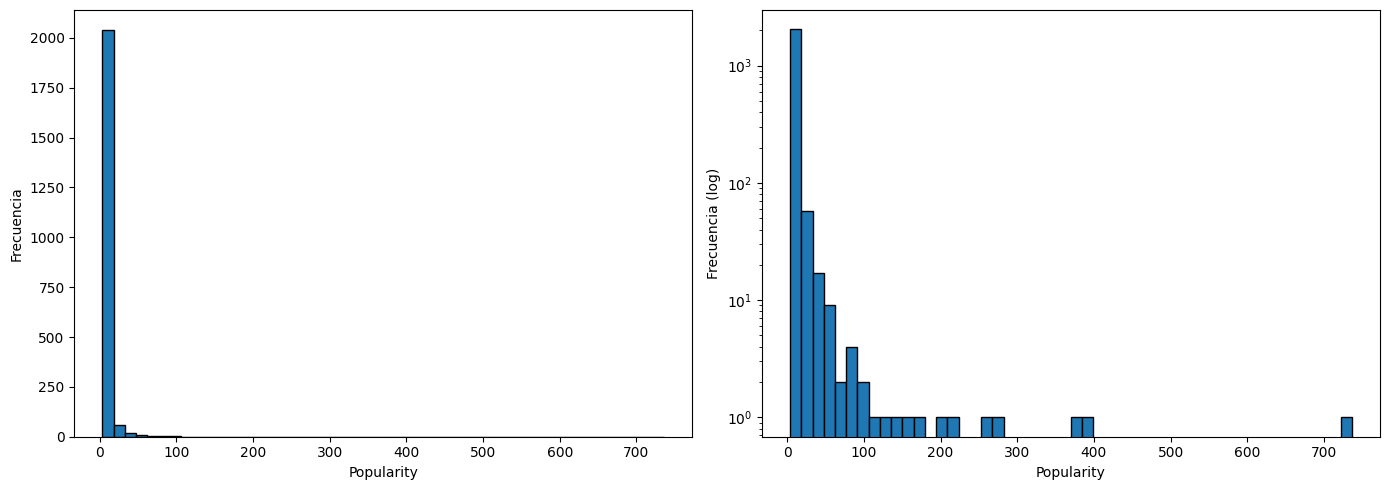

In [91]:
# Las pasamos a gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 
axes[0].hist(train_set['popularity'], bins=50, edgecolor='black')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Frecuencia')

# Histograma con escala logarítmica
axes[1].hist(train_set['popularity'], bins=50, edgecolor='black')
axes[1].set_yscale('log')
axes[1].set_xlabel('Popularity')
axes[1].set_ylabel('Frecuencia (log)')

plt.tight_layout()
plt.show();



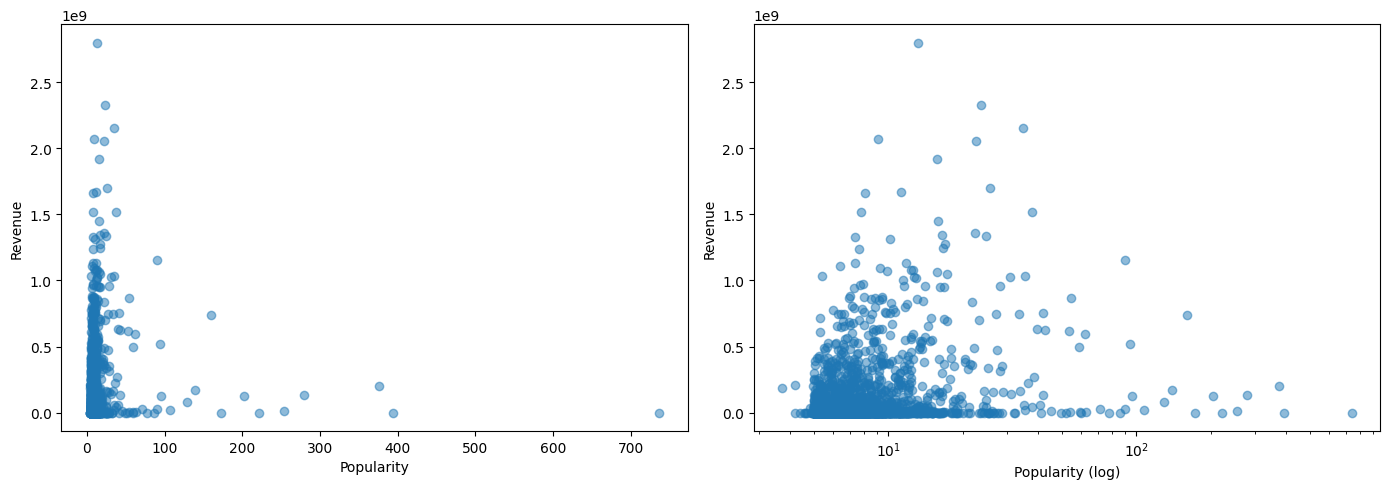

In [92]:
#  Relación con revenue
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(train_set['popularity'], train_set['revenue'], alpha=0.5)
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Revenue')
# ahora con la escala logarítmica
axes[1].scatter(train_set['popularity'], train_set['revenue'], alpha=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('Popularity (log)')
axes[1].set_ylabel('Revenue')
plt.tight_layout()
plt.show();

Apreciamos que la mayor parte de las películas presentan una popularidad cercana a cero. Por otra parte, es lógico pensar que los blockbusters destacan en esta variable. Aplicaremos una transformación con np.log1p debido a la gran cantidad de valores bajos y la presencia de outliers.
Podríamos plantearnos eliminarla, pero considero que teóricamente tiene un peso importante, así que la trataremos con cuidado, intentando aplicar algoritmos resistentes a los outliers.

In [93]:
train_set['log_popularity'] = np.log1p(train_set['popularity'])
print("Correlación popularity original:", train_set[['popularity', 'revenue']].corr().iloc[0,1])
print("Correlación log_popularity:", train_set[['log_popularity', 'revenue']].corr().iloc[0,1])

Correlación popularity original: 0.06538809857761942
Correlación log_popularity: 0.24262329118521803


In [94]:
# Como hemos mejorado la correlación, nos quedamos con log_popularity solo
train_set = train_set.drop(columns=['popularity'])
test_set['log_popularity'] = np.log1p(test_set['popularity'])
test_set = test_set.drop(columns=['popularity'])

Breve estudio de outliers: ¿Suponen un problema?


<Axes: >

Text(0.5, 1.0, 'Boxplot: budget')

<Axes: >

Text(0.5, 1.0, 'Boxplot: runtime')

<Axes: >

Text(0.5, 1.0, 'Boxplot: log_popularity')

<Axes: >

Text(0.5, 1.0, 'Boxplot: vote_average')

<Axes: >

Text(0.5, 1.0, 'Boxplot: vote_count')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

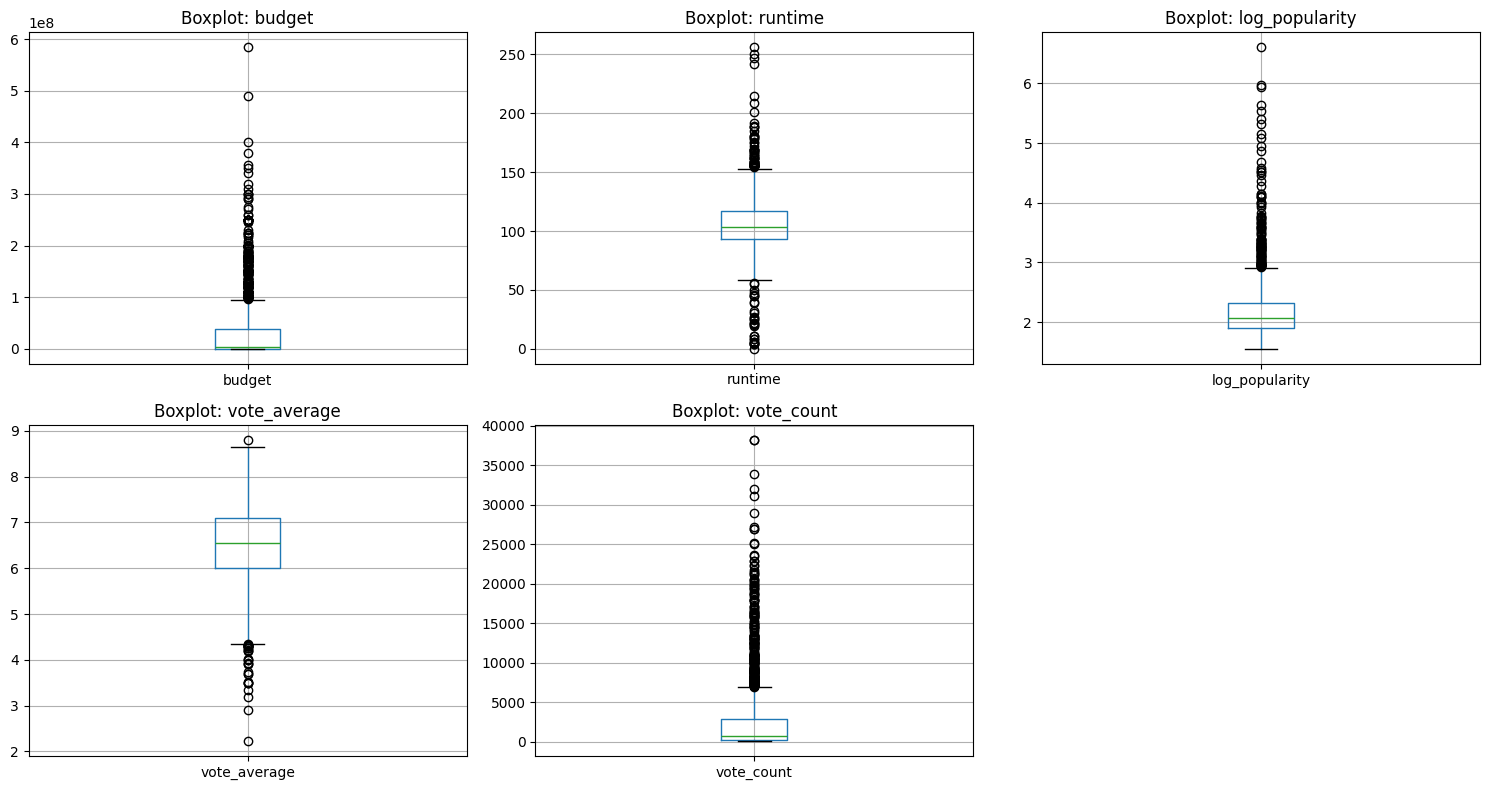

budget: 131 outliers extremos (6.1%)
runtime: 21 outliers extremos (1.0%)
vote_count: 115 outliers extremos (5.4%)


In [95]:
# Boxplots para detectar outliers, ahora con popularity_log ya creada
columnas_numericas = ['budget', 'runtime', 'log_popularity', 'vote_average', 'vote_count']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(columnas_numericas):
    ax = axes[i//3, i%3]
    train_set.boxplot(column=col, ax=ax)
    ax.set_title(f'Boxplot: {col}')
axes[1, 2].axis('off')    
plt.tight_layout()
plt.show();

# Outliers
for col in ['budget', 'runtime', 'vote_count']:
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_set[(train_set[col] < Q1 - 3*IQR) | (train_set[col] > Q3 + 3*IQR)]
    print(f"{col}: {len(outliers)} outliers extremos ({len(outliers)/len(train_set)*100:.1f}%)")

Se observan outliers en todas las variables, especialmente en budget. Estos valores extremos se mantendrán, ya que representan blockbusters o películas de gran éxito en taquilla.

Observamos también como hay peliculas con runtime = 0 o valores cercanos. Hagamos un pequeño análisis

In [96]:
print(f"Runtime mínimo: {train_set['runtime'].min()}")
print(f"Películas con runtime < 30: {(train_set['runtime'] < 30).sum()}")

Runtime mínimo: 0
Películas con runtime < 30: 20


In [97]:
print("Runtime = 0:")
print(train_set[train_set['runtime'] == 0][['title', 'runtime', 'budget', 'revenue']].head(10))

print("\n\nRuntime entre 1-29:")
print(train_set[(train_set['runtime'] > 0) & (train_set['runtime'] < 30)][['title', 'runtime', 'budget', 'revenue']].head(10))

Runtime = 0:
              title  runtime  budget  revenue
2672  Saint-Exupéry        0       0        0


Runtime entre 1-29:
                                  title  runtime  budget  revenue
1330            Olaf's Frozen Adventure       22       0        0
1829  Constantine: The House of Mystery       27       0        0
1270       Ice Age: A Mammoth Christmas       26       0        0
2030                               Quay        8       0        0
913                      Sing: Thriller       11       0        0
1313                   Scared Shrekless       21       0        0
338         The Bad Guys: Haunted Heist       25       0        0
818         Spider-Ham: Caught in a Ham        5       0        0
745               The Neighbors' Window       20       0        0
1403                          Terrifier       19       0        0


Identificamos cortos (runtime < 30). Presuponemos que pertenecen a plataformas y pueden considerarse outliers eliminables, ya que solo generarán ruido en nuestro modelo.

In [98]:
#  Eliminados
train_set = train_set[train_set['runtime'] >= 30].copy()
test_set = test_set[test_set['runtime'] >= 30].copy()

Haremos la matriz de correlación para analizar las correlaciones entre las variables numéricas.

<Figure size 1000x800 with 0 Axes>

<Axes: >

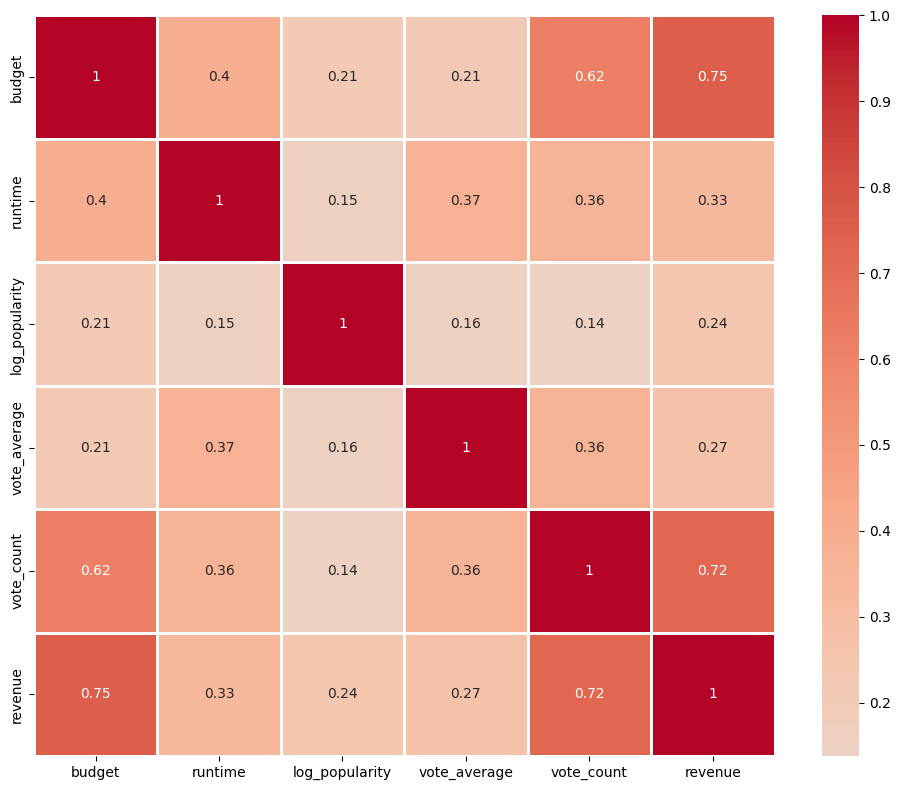

,budget,runtime,log_popularity,vote_average,vote_count,revenue
budget,1.000000,0.397738,0.210641,0.212066,0.618704,0.750849
runtime,0.397738,1.000000,0.153983,0.369043,0.363171,0.326049
log_popularity,0.210641,0.153983,1.000000,0.155801,0.137788,0.241778
vote_average,0.212066,0.369043,0.155801,1.000000,0.362068,0.268748
vote_count,0.618704,0.363171,0.137788,0.362068,1.000000,0.723698
revenue,0.750849,0.326049,0.241778,0.268748,0.723698,1.000000


In [99]:
# En este paso haremos la matriz de correlación
correlation_matrix = train_set[columnas_numericas + ['revenue']].corr()

# Visualizamos con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.tight_layout()
plt.show()

correlation_matrix

Como en el pairplot inicial, queda demostrado que nuestras columnas budget y vote_count son las que mayor correlación tienen con el target.
Presentan cierta multicolinealidad, pero tiene sentido si lo pensamos: a mayor budget, mayor campaña de marketing, lo que suele generar más interés en el público y, en consecuencia, un mayor número de votos.

---
### A continuación, el análisis a las columnas categóricas.
---

In [100]:
df.dtypes

title                          object
original_language              object
release_date                   object
budget                          int64
revenue                         int64
runtime                         int64
popularity                    float64
vote_average                  float64
vote_count                      int64
is_franchise                    int64
genres_names                   object
production_companies_names     object
production_countries_names     object
keywords_names                 object
cast_names                     object
crew_names                     object
similar_movies_names           object
dtype: object

In [101]:
columnas_categoricas = ['original_language', 'release_date', 'is_franchise', 'genres_names', 
               'production_companies_names', 'production_countries_names', 
               'keywords_names', 'cast_names', 'crew_names', 'similar_movies_names']


In [102]:
print(train_set['original_language'].nunique())
print(train_set['original_language'].value_counts().head(15))

37
original_language
en    1670
fr      82
es      56
ja      50
ko      42
it      41
de      31
hi      24
no      19
zh      18
pl      13
nl      11
da       8
sv       8
pt       7
Name: count, dtype: int64


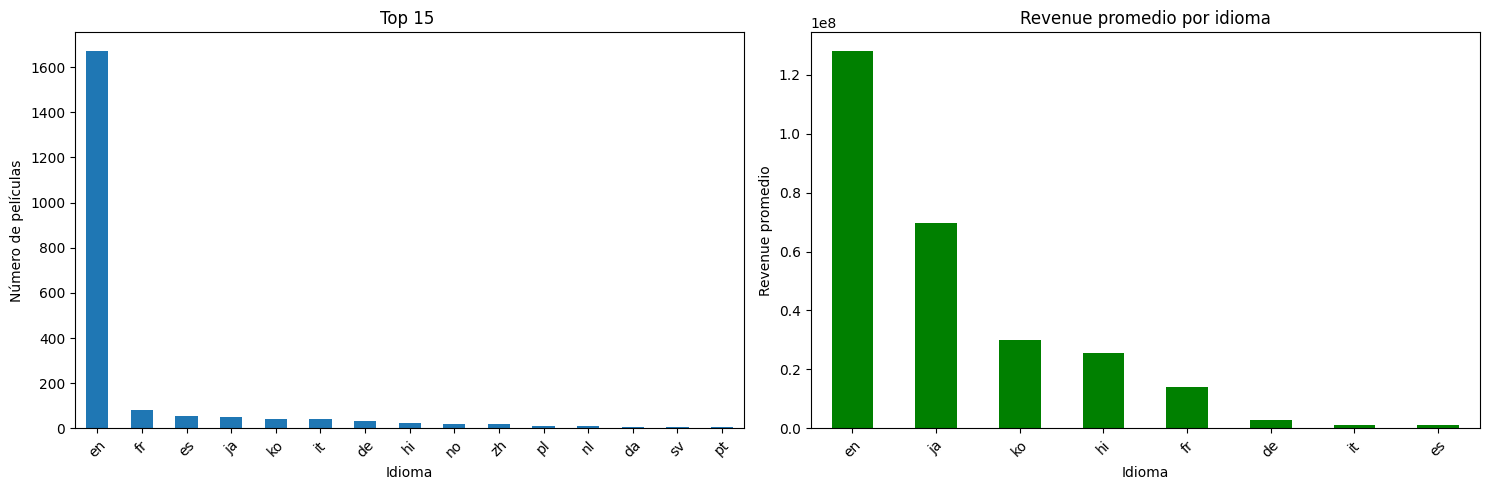

In [103]:
# Análisis de oritginal_language
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico ( top 15 idiomas)
train_set['original_language'].value_counts().head(15).plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 15 ')
axes[0].set_xlabel('Idioma')
axes[0].set_ylabel('Número de películas')
axes[0].tick_params(axis='x', rotation=45)

# Revenue medio por idioma (solo idiomas con más de 20 películas)
lang_revenue = train_set.groupby('original_language').agg({
    'revenue': 'mean',
    'title': 'count'
}).rename(columns={'title': 'count'})
lang_revenue = lang_revenue[lang_revenue['count'] >= 20].sort_values('revenue', ascending=False)

lang_revenue['revenue'].head(10).plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Revenue promedio por idioma')
axes[1].set_xlabel('Idioma')
axes[1].set_ylabel('Revenue promedio')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show();

Apreciamos la importancia del original_lenguage 'en', es un mercado dominado por Hollywood.


Vamos a segmentar los idiomas teniendo en cuenta hasta 'hi'. Aquellos con poca representación pasarán a ser 'other', con el propósito de que sigan aportando información

In [104]:
def categorizar_language(lang):
    top_langs = ['en', 'fr', 'es', 'ja', 'ko', 'it', 'de', 'hi']
    if lang in top_langs:
        return lang
    else:
        return 'other'

train_set['language_category'] = train_set['original_language'].apply(categorizar_language)
test_set['language_category'] = test_set['original_language'].apply(categorizar_language)

# Borramos la columna original_lenguage sustituyéndola por language_category con las principales ( hasta 24 películas, listón marcado por 'hi')
train_set = train_set.drop(columns=['original_language'])
test_set = test_set.drop(columns=['original_language'])

In [105]:
print(train_set['language_category'].value_counts())
print(train_set['language_category'].unique())

language_category
en       1670
other     126
fr         82
es         56
ja         50
ko         42
it         41
de         31
hi         24
Name: count, dtype: int64
['en' 'fr' 'de' 'ko' 'other' 'hi' 'ja' 'it' 'es']


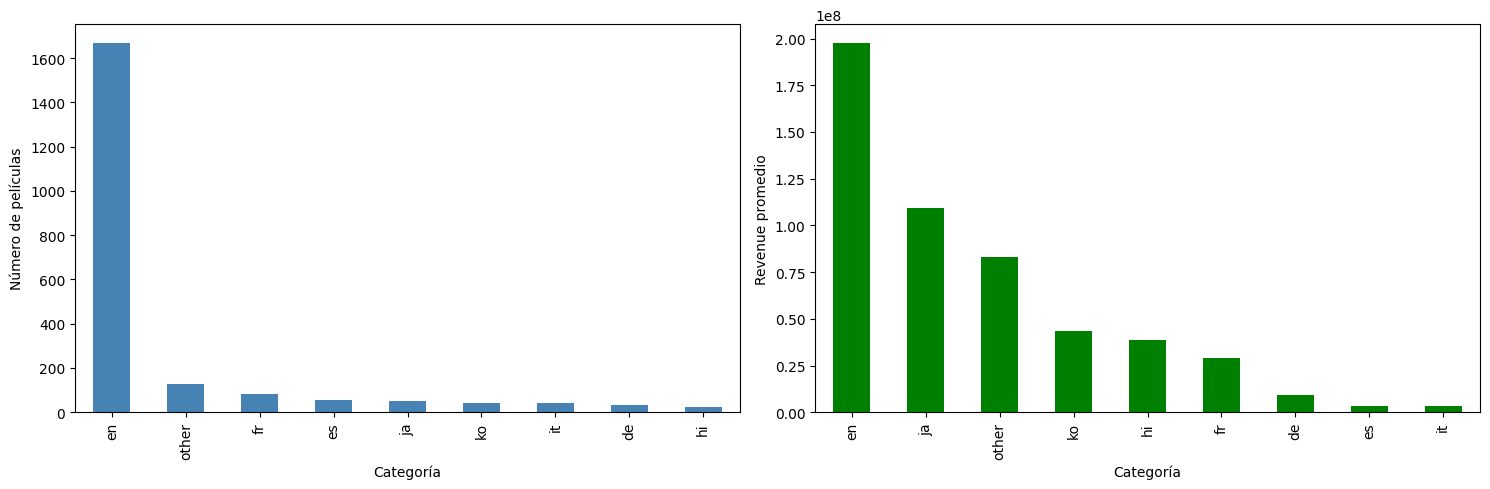

In [106]:
# Gráfico para language_category
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribución
train_set['language_category'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Número de películas')

# Revenue promedio
lang_revenue = train_set[train_set['revenue'] > 0].groupby('language_category')['revenue'].mean().sort_values(ascending=False)
lang_revenue.plot(kind='bar', ax=axes[1], color='green')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Revenue promedio')

plt.tight_layout()
plt.show();

Para la columa is_franchise


In [107]:
print(train_set['is_franchise'].nunique())
print(train_set['is_franchise'].value_counts().head(15))

2
is_franchise
0    1562
1     560
Name: count, dtype: int64


                  revenue                   
                     mean       median count
is_franchise                                
0              77574745.0   18878646.0   859
1             362199162.0  216657164.0   438


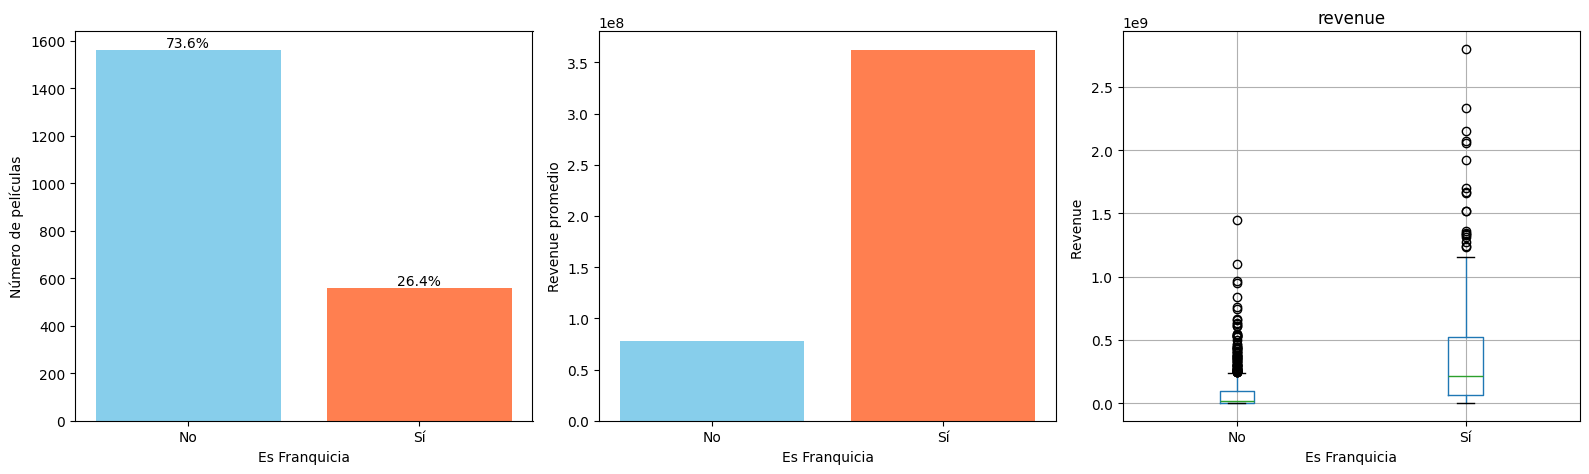

In [108]:
# Análisis de is_franchise

# Revenue (solo películas con revenue distinto a 0)

franchise_stats = train_set[train_set['revenue'] > 0].groupby('is_franchise').agg({
    'revenue': ['mean', 'median', 'count']
}).round(0)
print(franchise_stats)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico distribución
counts = train_set['is_franchise'].value_counts()
axes[0].bar(['No', 'Sí'], counts.values, color=['skyblue', 'coral'])
axes[0].set_xlabel('Es Franquicia')
axes[0].set_ylabel('Número de películas')
# Añadir porcentajes
for i, v in enumerate(counts.values):
    pct = v / len(train_set) * 100
    axes[0].text(i, v, f'{pct:.1f}%', ha='center', va='bottom')

# Gráfico revenue promedio
revenue_means = train_set[train_set['revenue'] > 0].groupby('is_franchise')['revenue'].mean()
axes[1].bar(['No', 'Sí'], revenue_means.values, color=['skyblue', 'coral'])
axes[1].set_xlabel('Es Franquicia')
axes[1].set_ylabel('Revenue promedio')

# Gráfico boxplot 
train_set[train_set['revenue'] > 0].boxplot(column='revenue', by='is_franchise', ax=axes[2])
axes[2].set_xlabel('Es Franquicia')
axes[2].set_xticklabels(['No', 'Sí'])
axes[2].set_ylabel('Revenue ')
plt.suptitle('')  # Eliminar título automático de pandas

plt.tight_layout()
plt.show();

Hay una distribución dispar. Vemos que las películas que forman parte de una franquicia, de media, tienen notablemente más revenue, aunque hay outliers en ambos grupos.

Para la columna 'release_date', vamos a estudiar por separado los años, nos servirá para analizar si existe una tendencia temporal a largo plazo (posibilidad de inflación). Por otro lado, estudiaremos los meses, en este veremos si hay estacionalidad.

In [109]:
train_set['release_year'] = pd.to_datetime(train_set['release_date']).dt.year
train_set['release_month'] = pd.to_datetime(train_set['release_date']).dt.month
test_set['release_year'] = pd.to_datetime(test_set['release_date']).dt.year
test_set['release_month'] = pd.to_datetime(test_set['release_date']).dt.month

<Axes: xlabel='release_year'>

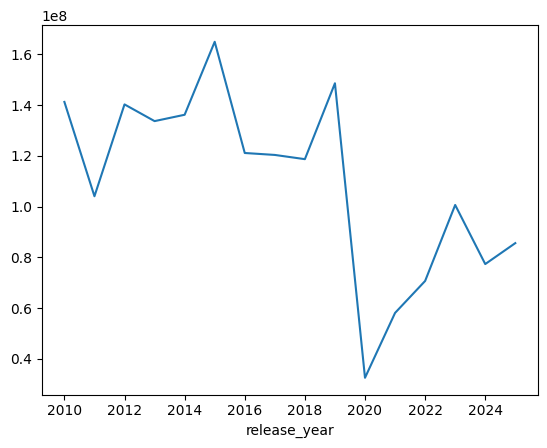

In [110]:
train_set.groupby('release_year')['revenue'].mean().plot()

<Axes: xlabel='release_month'>

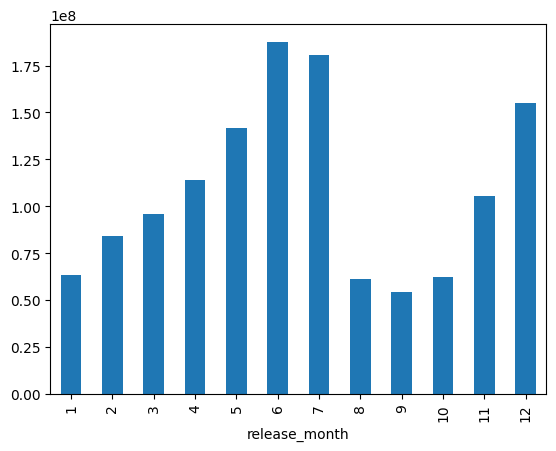

In [111]:
train_set.groupby('release_month')['revenue'].mean().plot(kind='bar')

In [112]:
# Borramos la columna release_date
train_set = train_set.drop(columns=['release_date'])
test_set = test_set.drop(columns=['release_date'])


De la columna release_year vemos claramente cómo la relación con revenue ha ido a la baja, marcada por la época Covid. Respecto a release_month observamos una clara estacionalidad con los picos en verano y diciembre.

La columna 'genres_names'

In [113]:
print(train_set['genres_names'].value_counts().head(15))

genres_names
['Drama']                                     99
['Horror', 'Thriller']                        74
['Comedy']                                    65
['Horror']                                    45
['Comedy', 'Drama']                           43
['Drama', 'Romance']                          38
['Action', 'Thriller']                        32
['Romance', 'Drama']                          31
['Action', 'Crime', 'Thriller']               31
['Action', 'Adventure', 'Science Fiction']    26
['Drama', 'Comedy']                           25
['Drama', 'History']                          24
['Comedy', 'Romance']                         23
['Documentary']                               22
['Horror', 'Mystery']                         21
Name: count, dtype: int64


<BarContainer object of 15 artists>

[Text(0, 0, 'Drama'),
 Text(1, 0, 'Action'),
 Text(2, 0, 'Thriller'),
 Text(3, 0, 'Comedy'),
 Text(4, 0, 'Adventure'),
 Text(5, 0, 'Horror'),
 Text(6, 0, 'Science Fiction'),
 Text(7, 0, 'Crime'),
 Text(8, 0, 'Romance'),
 Text(9, 0, 'Fantasy'),
 Text(10, 0, 'Family'),
 Text(11, 0, 'Animation'),
 Text(12, 0, 'Mystery'),
 Text(13, 0, 'History'),
 Text(14, 0, 'War')]

Text(0.5, 1.0, 'Top 15 géneros más frecuentes')

Text(0.5, 0, 'Género')

Text(0, 0.5, 'Número de películas')

<BarContainer object of 15 artists>

[Text(0, 0, 'Adventure'),
 Text(0, 1, 'Science Fiction'),
 Text(0, 2, 'Family'),
 Text(0, 3, 'Animation'),
 Text(0, 4, 'Fantasy'),
 Text(0, 5, 'Action'),
 Text(0, 6, 'Comedy'),
 Text(0, 7, 'Thriller'),
 Text(0, 8, 'Western'),
 Text(0, 9, 'War'),
 Text(0, 10, 'Crime'),
 Text(0, 11, 'Music'),
 Text(0, 12, 'History'),
 Text(0, 13, 'Drama'),
 Text(0, 14, 'Romance')]

Text(0.5, 1.0, 'Top 15 géneros por revenue promedio')

Text(0.5, 0, 'Revenue promedio ($)')

<Axes: >

Text(0.5, 1.0, 'Número de géneros por película')

Text(0.5, 0, 'Cantidad de géneros')

Text(0, 0.5, 'Número de películas')

<Axes: xlabel='num_genres'>

Text(0.5, 1.0, 'Revenue promedio según cantidad de géneros')

Text(0.5, 0, 'Número de géneros')

Text(0, 0.5, 'Revenue promedio ($)')

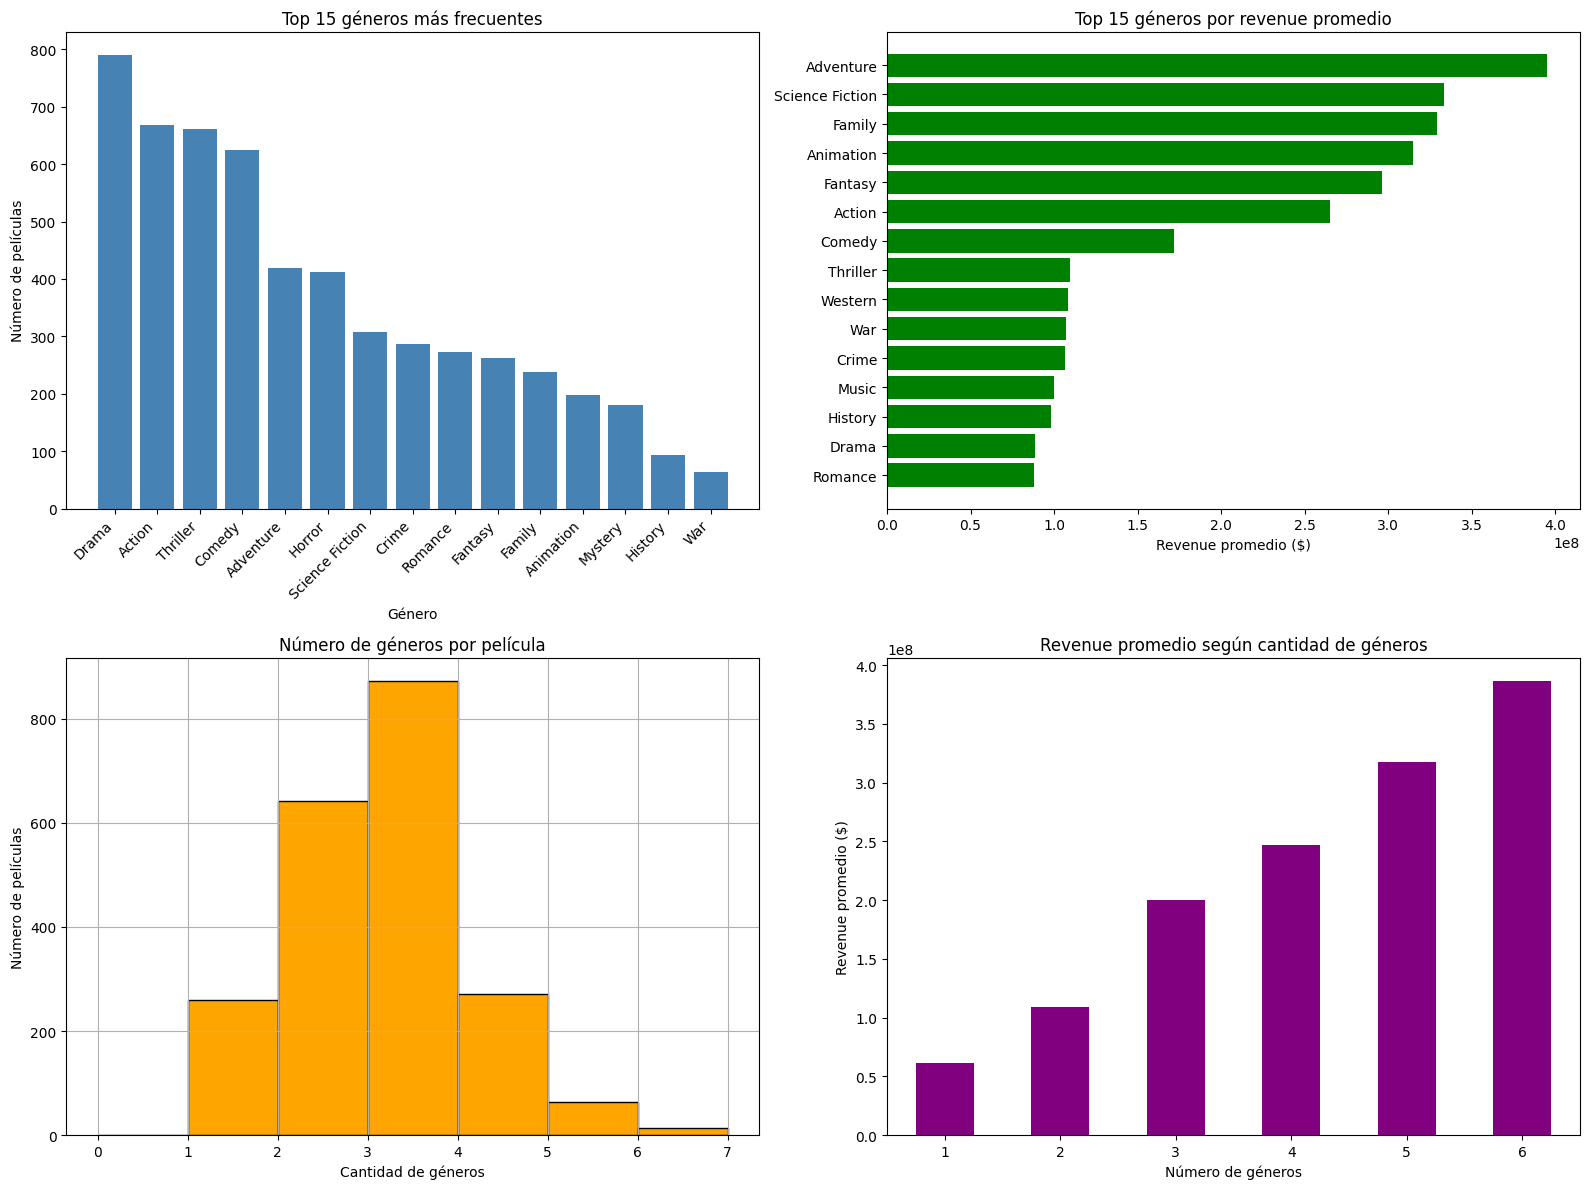

count    2122.000000
mean        2.658812
std         0.990997
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: num_genres, dtype: float64


In [114]:
# Análisis de Géneros
# Convertir strings a listas reales
train_set['genres_names'] = train_set['genres_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
test_set['genres_names'] = test_set['genres_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

#  Expandir géneros (flatten)
all_genres = []
for genres_list in train_set['genres_names']:
    if isinstance(genres_list, list):
        all_genres.extend(genres_list)

# Contar frecuencia de cada género individual
genre_counts = Counter(all_genres)

# Crear listas para cada columna
genres_list = []
total_movies_list = []
movies_with_revenue_list = []
avg_revenue_list = []

for genre, count in genre_counts.items():
    # Películas que contienen este género
    mask = train_set['genres_names'].apply(lambda x: genre in x if isinstance(x, list) else False)
    movies_with_genre = train_set[mask]
    movies_with_revenue = movies_with_genre[movies_with_genre['revenue'] > 0]
    
    if len(movies_with_revenue) > 0:
        genres_list.append(genre)
        total_movies_list.append(count)
        movies_with_revenue_list.append(len(movies_with_revenue))
        avg_revenue_list.append(movies_with_revenue['revenue'].mean())

# Crear DataFrame
genre_df = pd.DataFrame({
    'total_movies': total_movies_list,
    'movies_with_revenue': movies_with_revenue_list,
    'avg_revenue': avg_revenue_list
}, index=genres_list).sort_values('avg_revenue', ascending=False)

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Frecuencia de géneros (top 15)
top_15_genres = dict(genre_counts.most_common(15))
axes[0, 0].bar(range(len(top_15_genres)), list(top_15_genres.values()), color='steelblue')
axes[0, 0].set_xticks(range(len(top_15_genres)))
axes[0, 0].set_xticklabels(list(top_15_genres.keys()), rotation=45, ha='right')
axes[0, 0].set_title('Top 15 géneros más frecuentes')
axes[0, 0].set_xlabel('Género')
axes[0, 0].set_ylabel('Número de películas')

# Revenue por género (top 15)
top_revenue_genres = genre_df.head(15)
axes[0, 1].barh(range(len(top_revenue_genres)), top_revenue_genres['avg_revenue'], color='green')
axes[0, 1].set_yticks(range(len(top_revenue_genres)))
axes[0, 1].set_yticklabels(top_revenue_genres.index)
axes[0, 1].set_title('Top 15 géneros por revenue promedio')
axes[0, 1].set_xlabel('Revenue promedio ($)')
axes[0, 1].invert_yaxis()

# Número de géneros por película
train_set['num_genres'] = train_set['genres_names'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test_set['num_genres'] = test_set['genres_names'].apply(lambda x: len(x) if isinstance(x, list) else 0)
train_set['num_genres'].hist(bins=range(0, 8), ax=axes[1, 0], edgecolor='black', color='orange')
axes[1, 0].set_title('Número de géneros por película')
axes[1, 0].set_xlabel('Cantidad de géneros')
axes[1, 0].set_ylabel('Número de películas')
axes[1, 0].set_xticks(range(0, 8))

# Revenue vs número de géneros
genre_count_revenue = train_set[train_set['revenue'] > 0].groupby('num_genres')['revenue'].mean()
genre_count_revenue.plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Revenue promedio según cantidad de géneros')
axes[1, 1].set_xlabel('Número de géneros')
axes[1, 1].set_ylabel('Revenue promedio ($)')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show();

# Estadísticas de num_genres
print(train_set['num_genres'].describe())

Identificamos una gran cantidad de géneros, de los cuales podemos extraer los más relevantes (Drama, Action, Thriller, Comedy, Adventure, Horror, Family, Science Fiction, Animation, Fantasy) en función de su frecuencia y del revenue obtenido. Hemos creado columnas binarias con el objetivo de incluirlas en el modelo de Machine Learning.
Observamos una correlación clara entre el número de géneros que contiene la película y el revenue.

In [115]:
# Géneros seleccionados 
top_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Horror',
              'Drama', 'Family', 'Fantasy', 'Science Fiction', 'Thriller']

# Crear columnas binarias
for genre in top_genres:
    col_name = f'genre_{genre.lower().replace(" ", "_")}'
    train_set[col_name] = train_set['genres_names'].apply(
        lambda x: 1 if isinstance(x, list) and genre in x else 0
    )
    test_set[col_name] = test_set['genres_names'].apply(
        lambda x: 1 if isinstance(x, list) and genre in x else 0
    )

print(f" Creadas {len(top_genres)} columnas binarias de géneros")

# Verificar
genre_cols = [col for col in train_set.columns if col.startswith('genre_')]
print(f"Columnas de géneros: {genre_cols}")

 Creadas 10 columnas binarias de géneros
Columnas de géneros: ['genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy', 'genre_horror', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_science_fiction', 'genre_thriller']


Para las columnas crew y cast

In [116]:
print(train_set['cast_names'].nunique())
print(train_set['cast_names'].value_counts().head(15))

print(train_set['crew_names'].nunique())
print(train_set['crew_names'].value_counts().head(15))

print(f"Tipo: {type(train_set['cast_names'].iloc[0])}")
print(f"Ejemplo: {train_set['cast_names'].iloc[0]}")


print(f"Tipo: {type(train_set['crew_names'].iloc[0])}")
print(f"Ejemplo: {train_set['crew_names'].iloc[0]}")

2121
cast_names
['Bo Burnham']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [117]:


# Parsear cast y crew (convertir strings a listas)
train_set['cast_names'] = train_set['cast_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
train_set['crew_names'] = train_set['crew_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
test_set['cast_names'] = test_set['cast_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
test_set['crew_names'] = test_set['crew_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extraer actores individuales (cast)
all_actors = []
for cast_list in train_set['cast_names']:
    if isinstance(cast_list, list):
        all_actors.extend(cast_list)

actor_counts = Counter(all_actors)
print("Top 15 actores")
for actor, count in actor_counts.most_common(15):
    pct = count / len(train_set) * 100
    print(f"{actor}: {count} películas ({pct:.1f}%)")

# Extraer directores (crew)
all_crew = []
for crew_list in train_set['crew_names']:
    if isinstance(crew_list, list):
        all_crew.extend(crew_list)

crew_counts = Counter(all_crew)
print("Top 15 directores")
for crew, count in crew_counts.most_common(15):
    pct = count / len(train_set) * 100
    print(f"{crew}: {count} películas ({pct:.1f}%)")

# Revenue promedio de top 10 actores
print(" Revenue promedio de los 10 actores")
top_10_actors = [actor for actor, _ in actor_counts.most_common(10)]
for actor in top_10_actors:
    mask = train_set['cast_names'].apply(lambda x: actor in x if isinstance(x, list) else False)
    movies_with_actor = train_set[mask]
    movies_with_revenue = movies_with_actor[movies_with_actor['revenue'] > 0]
    if len(movies_with_revenue) > 0:
        avg_rev = movies_with_revenue['revenue'].mean()
        print(f"{actor}: ${avg_rev/1e6:.1f}M ({len(movies_with_revenue)} películas)")

Top 15 actores
Samuel L. Jackson: 25 películas (1.2%)
Keegan-Michael Key: 24 películas (1.1%)
J.K. Simmons: 23 películas (1.1%)
Fred Tatasciore: 22 películas (1.0%)
Woody Harrelson: 20 películas (0.9%)
Dee Bradley Baker: 19 películas (0.9%)
Chris Hemsworth: 19 películas (0.9%)
Chris Evans: 18 películas (0.8%)
Scarlett Johansson: 18 películas (0.8%)
Chris Pratt: 18 películas (0.8%)
Willem Dafoe: 17 películas (0.8%)
Ryan Reynolds: 17 películas (0.8%)
Dwayne Johnson: 17 películas (0.8%)
Liam Neeson: 17 películas (0.8%)
Josh Brolin: 17 películas (0.8%)
Top 15 directores
Dan O'Connell: 73 películas (3.4%)
Mary Vernieu: 62 películas (2.9%)
John T. Cucci: 57 películas (2.7%)
Stan Lee: 54 películas (2.5%)
Peter Burgis: 50 películas (2.4%)
Ethan Van der Ryn: 49 películas (2.3%)
Aaron Becker: 48 películas (2.3%)
Erik Aadahl: 48 películas (2.3%)
Randy Thom: 48 películas (2.3%)
Glen Gathard: 47 películas (2.2%)
Michael Miller: 46 películas (2.2%)
Sarah Halley Finn: 46 películas (2.2%)
Chris Navarr

Lista de actores famosos definida: 23 actores
has_famous_actor: 280 películas con actores famosos (13.2%)

Distribución de num_famous_actors:
num_famous_actors
0    1842
1     217
2      52
3       5
4       3
6       1
9       2
Name: count, dtype: int64
Impacto en revenue
                          mean  count
Sin actor famoso  1.228177e+08   1054
Con actor famoso  3.943624e+08    243
Revenue por número de actores famosos
                           mean  count
num_famous_actors                     
0                  1.228177e+08   1054
1                  3.388479e+08    183
2                  4.374056e+08     49
3                  3.664324e+08      5
4                  1.395064e+09      3
6                  1.518816e+09      1
9                  2.425927e+09      2


<Axes: xlabel='has_famous_actor'>

Text(0.5, 1.0, 'Distribución: ¿Tiene actor famoso?')

Text(0.5, 0, 'Tiene actor famoso')

[Text(0, 0, 'No'), Text(1, 0, 'Sí')]

Text(0, 0.5, 'Número de películas')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Revenue promedio según actor famoso')

Text(0.5, 0, 'Tiene actor famoso')

Text(0, 0.5, 'Revenue promedio ($)')

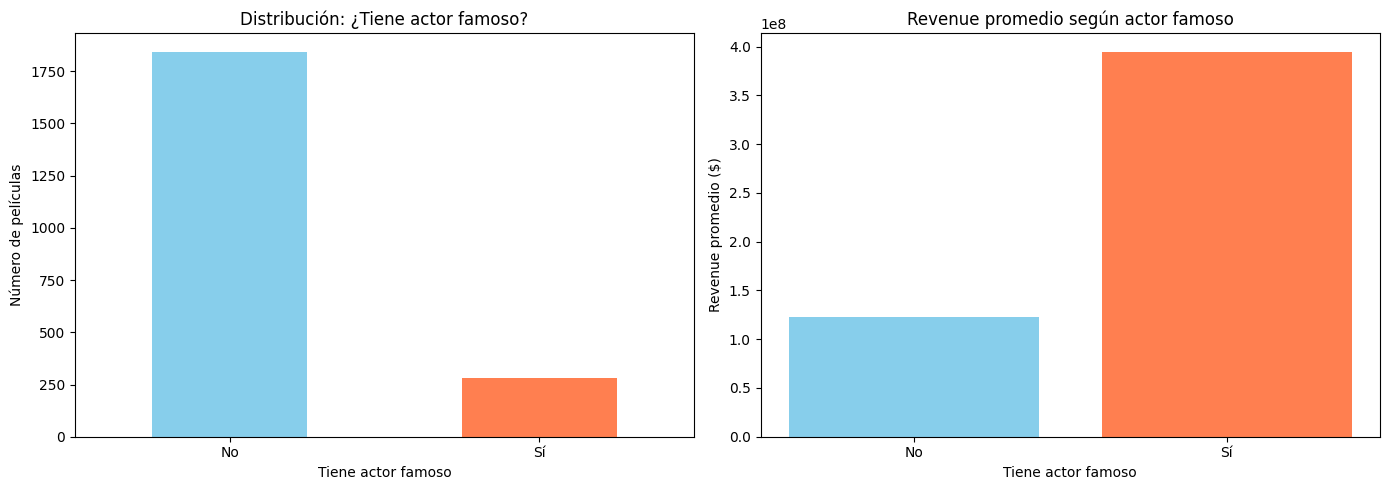


 Columnas de cast creadas: has_famous_actor, num_famous_actors


In [118]:
# Definir top actores (basado en frecuencia Y revenue alto)
top_actors = [
    'Samuel L. Jackson', 'Chris Hemsworth', 'Chris Evans', 'Scarlett Johansson',
    'Chris Pratt', 'Dwayne Johnson', 'Ryan Reynolds', 'Woody Harrelson',
    'J.K. Simmons', 'Willem Dafoe', 'Liam Neeson', 'Josh Brolin',
    'Keegan-Michael Key', 'Fred Tatasciore', 'Dee Bradley Baker',
    'Tom Cruise', 'Robert Downey Jr.', 'Mark Ruffalo', 'Tom Holland',
    'Zendaya', 'Margot Robbie', 'Will Smith', 'Leonardo DiCaprio'
]

print(f"Lista de actores famosos definida: {len(top_actors)} actores")

#  Crear features
# Feature 1: ¿Tiene al menos 1 actor famoso?
train_set['has_famous_actor'] = train_set['cast_names'].apply(
    lambda x: 1 if isinstance(x, list) and any(actor in top_actors for actor in x) else 0
)
test_set['has_famous_actor'] = test_set['cast_names'].apply(
    lambda x: 1 if isinstance(x, list) and any(actor in top_actors for actor in x) else 0
)

# Feature 2: ¿Cuántos actores famosos tiene?
train_set['num_famous_actors'] = train_set['cast_names'].apply(
    lambda x: sum(1 for actor in x if actor in top_actors) if isinstance(x, list) else 0
)
test_set['num_famous_actors'] = test_set['cast_names'].apply(
    lambda x: sum(1 for actor in x if actor in top_actors) if isinstance(x, list) else 0
)

#  Verificación
print(f"has_famous_actor: {train_set['has_famous_actor'].sum()} películas con actores famosos ({train_set['has_famous_actor'].mean()*100:.1f}%)")
print(f"\nDistribución de num_famous_actors:")
print(train_set['num_famous_actors'].value_counts().sort_index())

#  Análisis de impacto en revenue
print("Impacto en revenue")
revenue_by_famous = train_set[train_set['revenue'] > 0].groupby('has_famous_actor')['revenue'].agg(['mean', 'count'])
revenue_by_famous.index = ['Sin actor famoso', 'Con actor famoso']
print(revenue_by_famous)

print("Revenue por número de actores famosos")
revenue_by_num = train_set[train_set['revenue'] > 0].groupby('num_famous_actors')['revenue'].agg(['mean', 'count'])
print(revenue_by_num)

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico Distribución
train_set['has_famous_actor'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Distribución: ¿Tiene actor famoso?')
axes[0].set_xlabel('Tiene actor famoso')
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].set_ylabel('Número de películas')

# Gráfico Revenue promedio
revenue_means = train_set[train_set['revenue'] > 0].groupby('has_famous_actor')['revenue'].mean()
axes[1].bar(['No', 'Sí'], revenue_means.values, color=['skyblue', 'coral'])
axes[1].set_title('Revenue promedio según actor famoso')
axes[1].set_xlabel('Tiene actor famoso')
axes[1].set_ylabel('Revenue promedio ($)')

plt.tight_layout()
plt.show()

print("\n Columnas de cast creadas: has_famous_actor, num_famous_actors")

La distribución es la lógica, hay mayor cantidad de películas sin un actor reconocido.
Podemos observar una gran correlación entre la presencia de un actor de renombre y el revenue.
Por último, la columna crew no indica directores, por lo que la eliminaremos más adelante.

Columna production_countries


Total de países únicos: 66

Top 15 países más frecuentes:
  United States of America: 1519 películas (71.6%)
  United Kingdom: 309 películas (14.6%)
  France: 184 películas (8.7%)
  Canada: 149 películas (7.0%)
  Germany: 97 películas (4.6%)
  Spain: 73 películas (3.4%)
  Japan: 72 películas (3.4%)
  Belgium: 64 películas (3.0%)
  Australia: 64 películas (3.0%)
  Italy: 61 películas (2.9%)
  China: 50 películas (2.4%)
  South Korea: 47 películas (2.2%)
  India: 47 películas (2.2%)
  Sweden: 29 películas (1.4%)
  Ireland: 28 películas (1.3%)
Revenue medio por país (TOP 10)
United States of America: $208.1M (1022 películas)
United Kingdom: $148.6M (208 películas)
France: $52.5M (120 películas)
Canada: $95.8M (80 películas)
Germany: $55.1M (59 películas)
Spain: $41.7M (32 películas)
Japan: $158.1M (52 películas)
Belgium: $51.8M (34 películas)
Australia: $77.5M (44 películas)
Italy: $14.3M (24 películas)
Comparación: 
USA: $208.1M promedio (1022 películas con revenue)
No-USA: $45.6M prome

<Axes: xlabel='is_usa_production'>

Text(0.5, 1.0, 'Distribución: USA vs resto del mundo')

Text(0.5, 0, 'Producción USA')

[Text(0, 0, 'No'), Text(1, 0, 'Sí')]

Text(0, 0.5, 'Número de películas')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Revenue promedio por país')

Text(0.5, 0, 'Producción')

Text(0, 0.5, 'Revenue promedio ($)')

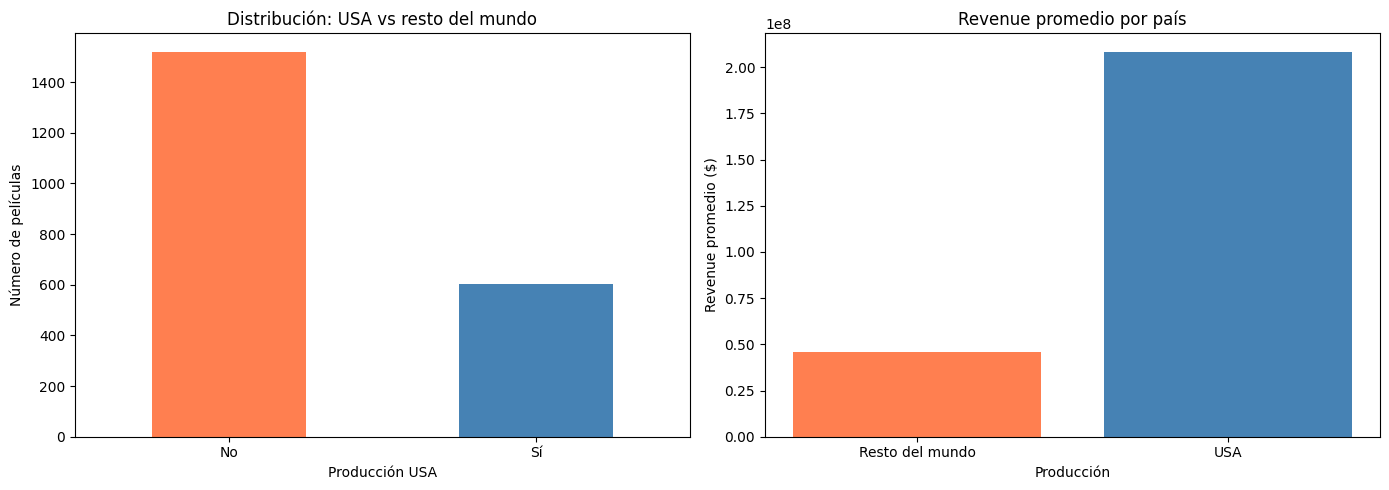

In [119]:
# Parsear (convertir strings a listas)
train_set['production_countries_names'] = train_set['production_countries_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
test_set['production_countries_names'] = test_set['production_countries_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extraer países individuales
all_countries = []
for countries_list in train_set['production_countries_names']:
    if isinstance(countries_list, list):
        all_countries.extend(countries_list)

country_counts = Counter(all_countries)
print(f"\nTotal de países únicos: {len(country_counts)}")
print(f"\nTop 15 países más frecuentes:")
for country, count in country_counts.most_common(15):
    pct = count / len(train_set) * 100
    print(f"  {country}: {count} películas ({pct:.1f}%)")

#  Revenue promedio por país (top 10)
print("Revenue medio por país (TOP 10)")


top_10_countries = [country for country, _ in country_counts.most_common(10)]
for country in top_10_countries:
    mask = train_set['production_countries_names'].apply(
        lambda x: country in x if isinstance(x, list) else False
    )
    movies_with_country = train_set[mask]
    movies_with_revenue = movies_with_country[movies_with_country['revenue'] > 0]
    
    if len(movies_with_revenue) > 0:
        avg_rev = movies_with_revenue['revenue'].mean()
        print(f"{country}: ${avg_rev/1e6:.1f}M ({len(movies_with_revenue)} películas)")

# 4. Comparación USA vs resto del mundo
print("Comparación: ")

usa_mask = train_set['production_countries_names'].apply(
    lambda x: isinstance(x, list) and 'United States of America' in x
)
usa_movies = train_set[usa_mask & (train_set['revenue'] > 0)]
non_usa_movies = train_set[~usa_mask & (train_set['revenue'] > 0)]

print(f"USA: ${usa_movies['revenue'].mean()/1e6:.1f}M promedio ({len(usa_movies)} películas con revenue)")
print(f"No-USA: ${non_usa_movies['revenue'].mean()/1e6:.1f}M promedio ({len(non_usa_movies)} películas con revenue)")
print(f"Diferencia: {usa_movies['revenue'].mean() / non_usa_movies['revenue'].mean():.2f}x")

# Crear columna (is_usa_production)
train_set['is_usa_production'] = train_set['production_countries_names'].apply(
    lambda x: 1 if isinstance(x, list) and 'United States of America' in x else 0
)
test_set['is_usa_production'] = test_set['production_countries_names'].apply(
    lambda x: 1 if isinstance(x, list) and 'United States of America' in x else 0
)
print(f"is_usa_production:")
print(f"  - {train_set['is_usa_production'].sum()} películas USA ({train_set['is_usa_production'].mean()*100:.1f}%)")
print(f"  - {(~train_set['is_usa_production'].astype(bool)).sum()} películas No-USA ({(1-train_set['is_usa_production'].mean())*100:.1f}%)")

# Gráfico simple

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico  Distribución USA vs resto del mundo
train_set['is_usa_production'].value_counts().plot(kind='bar', ax=axes[0], color=['coral', 'steelblue'])
axes[0].set_title('Distribución: USA vs resto del mundo')
axes[0].set_xlabel('Producción USA')
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].set_ylabel('Número de películas')

# Gráfico  Revenue promedio USA vs resto del mundo
revenue_means = train_set[train_set['revenue'] > 0].groupby('is_usa_production')['revenue'].mean()
axes[1].bar(['Resto del mundo', 'USA'], revenue_means.values, color=['coral', 'steelblue'])
axes[1].set_title('Revenue promedio por país')
axes[1].set_xlabel('Producción')
axes[1].set_ylabel('Revenue promedio ($)')

plt.tight_layout()
plt.show()

Observamos un claro dominio de las producciones Estadounindenses, así como su relación con revenue.


Columna production_companies

In [120]:
# Parsear (convertir strings a listas)
train_set['production_companies_names'] = train_set['production_companies_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
test_set['production_companies_names'] = test_set['production_companies_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extraer estudios individuales
all_companies = []
for companies_list in train_set['production_companies_names']:
    if isinstance(companies_list, list):
        all_companies.extend(companies_list)

company_counts = Counter(all_companies)
print(f"\nTotal de estudios/productoras únicos: {len(company_counts)}")
print(f"\nTop 20 productoras más frecuentes:")
for company, count in company_counts.most_common(20):
    pct = count / len(train_set) * 100
    print(f"  {company}: {count} películas ({pct:.1f}%)")

# Revenue promedio por estudio (top 15)
print("Revenue medio por estudio (TOP 15)")
top_15_companies = [company for company, _ in company_counts.most_common(15)]
company_revenue_data = []

for company in top_15_companies:
    mask = train_set['production_companies_names'].apply(
        lambda x: company in x if isinstance(x, list) else False
    )
    movies_with_company = train_set[mask]
    movies_with_revenue = movies_with_company[movies_with_company['revenue'] > 0]
    
    if len(movies_with_revenue) > 0:
        avg_rev = movies_with_revenue['revenue'].mean()
        company_revenue_data.append((company, avg_rev, len(movies_with_revenue)))
        print(f"{company}: ${avg_rev/1e6:.1f}M ({len(movies_with_revenue)} películas)")

#  Identificar productoras exitosas
print("Productoras de éxito")


Total de estudios/productoras únicos: 3750

Top 20 productoras más frecuentes:
  Universal Pictures: 84 películas (4.0%)
  Warner Bros. Pictures: 80 películas (3.8%)
  Columbia Pictures: 67 películas (3.2%)
  Paramount Pictures: 61 películas (2.9%)
  Lionsgate: 60 películas (2.8%)
  TSG Entertainment: 47 películas (2.2%)
  20th Century Fox: 39 películas (1.8%)
  Blumhouse Productions: 39 películas (1.8%)
  Walt Disney Pictures: 33 películas (1.6%)
  New Line Cinema: 33 películas (1.6%)
  Legendary Pictures: 28 películas (1.3%)
  StudioCanal: 27 películas (1.3%)
  Marvel Studios: 27 películas (1.3%)
  Focus Features: 25 películas (1.2%)
  DreamWorks Animation: 25 películas (1.2%)
  RatPac Entertainment: 22 películas (1.0%)
  A24: 21 películas (1.0%)
  FilmNation Entertainment: 21 películas (1.0%)
  Ingenious Media: 21 películas (1.0%)
  Summit Entertainment: 20 películas (0.9%)
Revenue medio por estudio (TOP 15)
Universal Pictures: $319.4M (80 películas)
Warner Bros. Pictures: $357.3M 

Productoras: 10
 Walt Disney Pictures: 33 películas
 Warner Bros. Pictures: 80 películas
 Universal Pictures: 84 películas
 Marvel Studios: 27 películas
 Paramount Pictures: 61 películas
 20th Century Fox: 39 películas
 Columbia Pictures: 67 películas
 New Line Cinema: 33 películas
 DreamWorks Pictures: 11 películas
 Legendary Pictures: 28 películas
Columna creada
has_major_studio:
  - 437 películas con major studio (20.6%)
  - 1685 películas indie (79.4%)
 Comparación productoras de éxito vs indies
Major Studio: $355.3M promedio (412 películas)
Indie: $89.2M promedio (885 películas)
Diferencia: 3.99x


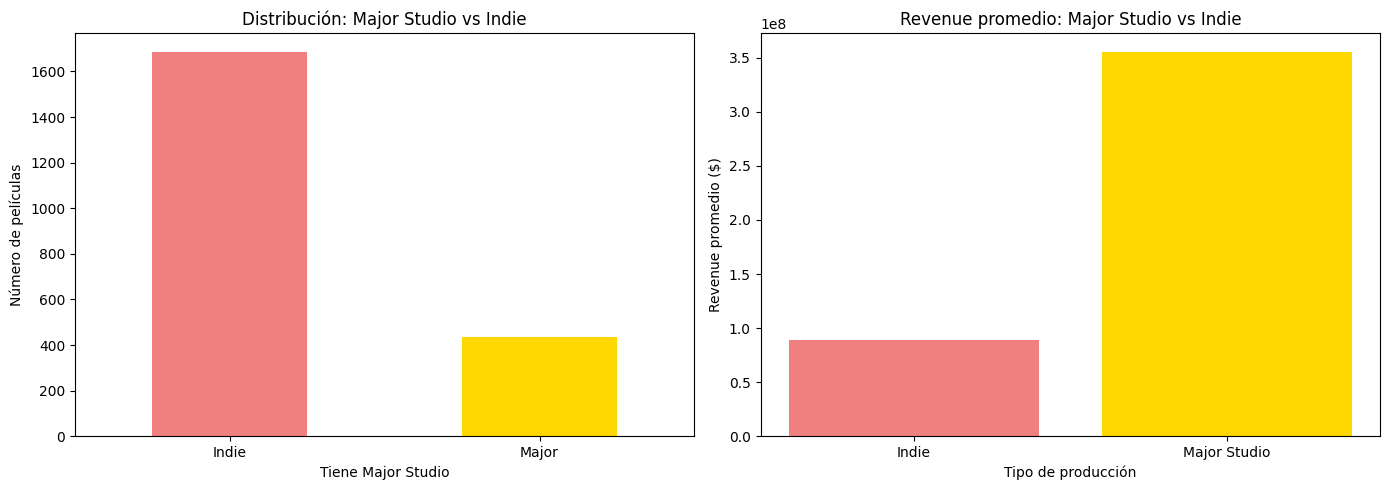

In [121]:
# Lista de estudios conocidos
major_studios = [
    'Walt Disney Pictures', 'Warner Bros. Pictures', 'Universal Pictures',
    'Marvel Studios', 'Paramount Pictures', '20th Century Fox',
    'Columbia Pictures', 'New Line Cinema', 'DreamWorks Pictures',
    'Legendary Pictures'
]

print(f"Productoras: {len(major_studios)}")
for studio in major_studios:
    if studio in company_counts:
        print(f" {studio}: {company_counts[studio]} películas")

# Crear columna (has_major_studio)
train_set['has_major_studio'] = train_set['production_companies_names'].apply(
    lambda x: 1 if isinstance(x, list) and any(studio in x for studio in major_studios) else 0
)
test_set['has_major_studio'] = test_set['production_companies_names'].apply(
    lambda x: 1 if isinstance(x, list) and any(studio in x for studio in major_studios) else 0
)

print("Columna creada")
print(f"has_major_studio:")
print(f"  - {train_set['has_major_studio'].sum()} películas con major studio ({train_set['has_major_studio'].mean()*100:.1f}%)")
print(f"  - {(~train_set['has_major_studio'].astype(bool)).sum()} películas indie ({(1-train_set['has_major_studio'].mean())*100:.1f}%)")

# Comparación revenue
print(" Comparación productoras de éxito vs indies")

major_movies = train_set[train_set['has_major_studio'] == 1]
indie_movies = train_set[train_set['has_major_studio'] == 0]

major_with_revenue = major_movies[major_movies['revenue'] > 0]
indie_with_revenue = indie_movies[indie_movies['revenue'] > 0]

print(f"Major Studio: ${major_with_revenue['revenue'].mean()/1e6:.1f}M promedio ({len(major_with_revenue)} películas)")
print(f"Indie: ${indie_with_revenue['revenue'].mean()/1e6:.1f}M promedio ({len(indie_with_revenue)} películas)")
if len(indie_with_revenue) > 0:
    print(f"Diferencia: {major_with_revenue['revenue'].mean() / indie_with_revenue['revenue'].mean():.2f}x")

# Gráficos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico Distribución Major vs Indie
train_set['has_major_studio'].value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'gold'])
axes[0].set_title('Distribución: Major Studio vs Indie')
axes[0].set_xlabel('Tiene Major Studio')
axes[0].set_xticklabels(['Indie', 'Major'], rotation=0)
axes[0].set_ylabel('Número de películas')

# Gráfico Revenue promedio
revenue_means = train_set[train_set['revenue'] > 0].groupby('has_major_studio')['revenue'].mean()
axes[1].bar(['Indie', 'Major Studio'], revenue_means.values, color=['lightcoral', 'gold'])
axes[1].set_title('Revenue promedio: Major Studio vs Indie')
axes[1].set_xlabel('Tipo de producción')
axes[1].set_ylabel('Revenue promedio ($)')

plt.tight_layout()
plt.show();


Podemos observar la clara diferencia en número de películas provenientes de productoras más pequeñas respecto a las "Major". Por contraparte, las "Major" ganan claramente en taquilla.

In [122]:
train_set.columns

Index(['title', 'budget', 'revenue', 'runtime', 'vote_average', 'vote_count',
       'is_franchise', 'genres_names', 'production_companies_names',
       'production_countries_names', 'keywords_names', 'cast_names',
       'crew_names', 'similar_movies_names', 'log_popularity',
       'language_category', 'release_year', 'release_month', 'num_genres',
       'genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy',
       'genre_horror', 'genre_drama', 'genre_family', 'genre_fantasy',
       'genre_science_fiction', 'genre_thriller', 'has_famous_actor',
       'num_famous_actors', 'is_usa_production', 'has_major_studio'],
      dtype='object')

In [123]:
# Columnas a eliminar
columns_to_drop = [
    # Columnas originales procesadas (ya tenemos features derivadas)
    'genres_names',
    'cast_names',
    'production_countries_names',
    'production_companies_names',
    'crew_names',
    'keywords_names',
    'similar_movies_names',
]

In [124]:
# Eliminar en ambos datasets
train_set = train_set.drop(columns=columns_to_drop)
test_set = test_set.drop(columns=columns_to_drop)

In [125]:
train_set.columns

Index(['title', 'budget', 'revenue', 'runtime', 'vote_average', 'vote_count',
       'is_franchise', 'log_popularity', 'language_category', 'release_year',
       'release_month', 'num_genres', 'genre_action', 'genre_adventure',
       'genre_animation', 'genre_comedy', 'genre_horror', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_science_fiction',
       'genre_thriller', 'has_famous_actor', 'num_famous_actors',
       'is_usa_production', 'has_major_studio'],
      dtype='object')

## Resumen Final del EDA

### Columnas Finales del Dataset (26 columnas)

#### 1. Identificador (1 columna)
- `title`: Título de la película (para referencia)

#### 2. Variables Numéricas Continuas (7 columnas)
- `budget`: Presupuesto de producción ($)
- `revenue`: Recaudación en taquilla ($) (target)
- `runtime`: Duración de la película (minutos)
- `vote_average`: Puntuación promedio (escala 0-10)
- `vote_count`: Número de votos recibidos
- `log_popularity`: Logaritmo de la popularidad (transformación aplicada)
- `release_year`: Año de estreno

#### 3. Variables Numéricas Discretas/Binarias (7 columnas)
- `release_month`: Mes de estreno (1-12)
- `is_franchise`: Pertenece a franquicia (0 = No, 1 = Sí)
- `num_genres`: Número total de géneros por película
- `has_famous_actor`: Tiene actor famoso (0 = No, 1 = Sí)
- `num_famous_actors`: Cantidad de actores famosos en el cast
- `is_usa_production`: Producción estadounidense (0 = No, 1 = Sí)
- `has_major_studio`: Producida por major studio (0 = No, 1 = Sí)

#### 4. Géneros - Columnas Binarias (10 columnas)
- `genre_action`: Género Acción (0 = No, 1 = Sí)
- `genre_adventure`: Género Aventura (0 = No, 1 = Sí)
- `genre_animation`: Género Animación (0 = No, 1 = Sí)
- `genre_comedy`: Género Comedia (0 = No, 1 = Sí)
- `genre_drama`: Género Drama (0 = No, 1 = Sí)
- `genre_family`: Género Familiar (0 = No, 1 = Sí)
- `genre_fantasy`: Género Fantasía (0 = No, 1 = Sí)
- `genre_horror`: Género Terror (0 = No, 1 = Sí)
- `genre_science_fiction`: Género Ciencia Ficción (0 = No, 1 = Sí)
- `genre_thriller`: Género Thriller (0 = No, 1 = Sí)

#### 5. Variable Categórica (1 columna)
- `language_category`: Categoría de idioma original (9 valores: en, fr, es, ja, ko, it, de, hi, other)
  - **Nota:** Requiere One-Hot Encoding en el pipeline de preprocesamiento

---

### Dimensiones del Dataset

- **Train set:** 2,122 películas × 26 columnas
- **Test set:** 748 películas × 26 columnas
- **Ratio features/muestras:** 1:82

---

### Feature Engineering Aplicado

#### Transformaciones:
- `popularity` → `log_popularity` (normalización logarítmica para reducir asimetría)
- `original_language` → `language_category` (agrupación en 9 categorías: top 8 idiomas + "other")
- `release_date` → `release_year` + `release_month` (extracción de componentes temporales)

#### Features derivadas de variables multi-valor:
- `genres_names` → 10 géneros binarios + `num_genres`
- `cast_names` → `has_famous_actor` + `num_famous_actors`
- `production_countries_names` → `is_usa_production`
- `production_companies_names` → `has_major_studio`

---

### Variables Descartadas

**Columnas originales procesadas:**
- `original_language` (reemplazada por `language_category`)
- `release_date` (reemplazada por `release_year` y `release_month`)
- `genres_names` (reemplazada por columnas binarias de géneros)
- `cast_names` (reemplazada por features agregadas de actores)
- `production_countries_names` (reemplazada por `is_usa_production`)
- `production_companies_names` (reemplazada por `has_major_studio`)

**Columnas descartadas por bajo valor predictivo o problemas:**
- `crew_names`: Mayoría técnicos de sonido, no directores. Carece de relevancia
- `keywords_names`: 2,098 combinaciones únicas, excesivamente ruidoso y redundante con géneros
- `similar_movies_names`: Información generada post-estreno, no disponible para predicción

---

In [126]:
train_set.to_csv('train_set_clean.csv', index=False)
test_set.to_csv('test_set_clean.csv', index=False)